In [ ]:
using DrWatson
@quickactivate "Simulation"
include(srcdir("TienGordon.jl"))

import .TienGordon as TG
using CairoMakie
using ProgressMeter
using ColorSchemes
using Statistics
using JLD2

Threads.nthreads()

In [5]:
TG.ν = 15E9
TG.Δ = 189e-6
TG.n = 100
TG.m = collect(1:20)
TG.load_reference(
    # TG.ReferenceDesc(joinpath(datadir(),"HighRes","iv-T0.0K.jld2"), "filtered")
    TG.ReferenceDesc(joinpath(datadir(),"Reference","Individuals.hdf5"), "")
    ;type=TG.multiple
)

V₀ = TG.reference.V0[1:2:end]
Vω = collect(0:0.1:25);

In [ ]:
τ = []

for t in τ
    TG.τ = t

    z = Matrix{Float64}(undef, length(V₀), length(Vω))
    progress = Progress(length(Vω), 1, "Working...")
    Threads.@threads for i in 1:lastindex(Vω)
        next!(progress)
        z[:, i] = TG.IV₀.(V₀, Vω[i])
    end

    dz = Matrix{Float64}(undef, length(V₀) - 1, length(Vω))
    for i in 1:lastindex(Vω)
        dz[:, i] = diff(z[:, i]) ./ diff(V₀)
    end

    jldopen(joinpath(datadir(), "TG-IV.jld2"), "r+") do file
        if haskey(file, "τ=$(TG.τ)")
            delete!(file, "τ=$(TG.τ)")
        end
        dir = JLD2.Group(file, "τ=$(TG.τ)")

        dir["params"] = Dict(
            "ν" => TG.ν,
            "Δ" => TG.Δ,
            "τ" => TG.τ,
            "n" => TG.n,
            "m" => TG.m,
            "V0" => (minimum(V₀), V₀[2]-V₀[1], maximum(V₀)),
            "Vω" => (minimum(Vω), Vω[2]-Vω[1], maximum(Vω)),
        )
        dir["Axes"] = Dict(
            "x" => ("V0", V₀),
            "y" => ("Vω", Vω),
        )
        dir["IV"] = z
        dir["dIdV"] = dz

        # print available dirs
        println("Available directories:")
        println(keys(file))
    end;
end

In [12]:
τ = [0.5,0.35,0.28,0.25,0.25,0.25]

z_sum = Matrix{Float64}(undef, length(V₀), length(Vω))
dz_sum = Matrix{Float64}(undef, length(V₀) - 1, length(Vω))
for t in τ
    jldopen(joinpath(datadir(), "TG-IV.jld2"), "r") do file
        dir = file["τ=$(t)"]
        global z_sum += dir["IV"]
        global dz_sum += dir["dIdV"]
    end
end

In [8]:
# clim = (mean(filter(!isnan, dz)) - std(filter(!isnan, dz)), 
#         mean(filter(!isnan, dz)) + std(filter(!isnan, dz)));
see = get(ColorSchemes.ice, range(0.0, 1.0, length=512));

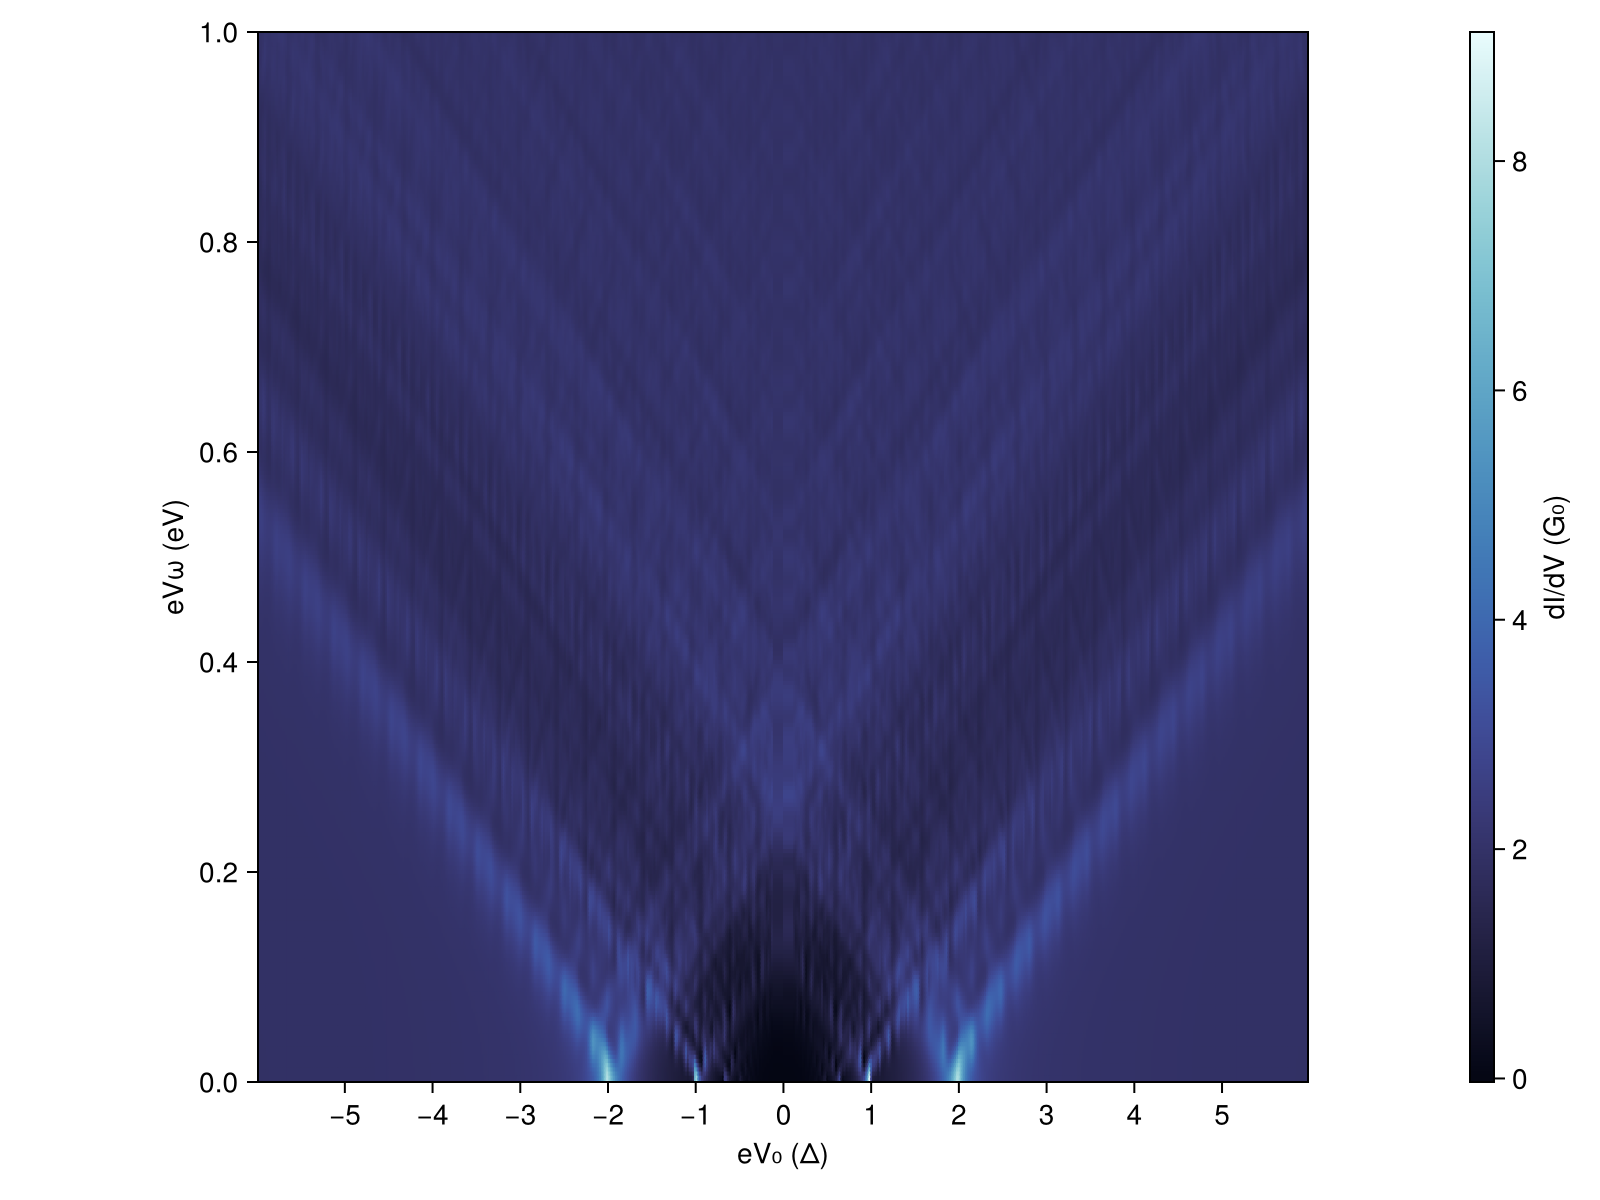

CairoMakie.Screen{IMAGE}


In [15]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1], aspect=1)

plt = heatmap!(ax, V₀[1:end-1], Vω*0.04, dz_sum, colormap=see)
Colorbar(fig[1, 2], plt, label="dI/dV (G₀)")
ax.xlabel = "eV₀ (Δ)"
ax.ylabel = "eVω (eV)"
ax.limits = (V₀[1], V₀[end]), (0.0, 1.0)
ax.yticks = 0:0.2:1.0
ax.xticks = round(V₀[1]):1:round(V₀[end])

display(fig)

In [16]:
save(plotsdir("TG_PAMAR_IV-M$(maximum(TG.m))-G$(sum(τ))G₀.png"), fig)

In [78]:
# ref_V0, ref_I0 = TG.reference.V0, TG.reference.I0
# # ref_I0 = fixer(ref_I0)

# evolution = 200
# fact = 3

# fig = Figure()

# ax = Axis(fig[1, 1])

# lines!(ax, ref_V0, ref_I0*fact, color = :Blue, label = "Reference")
# lines!(ax, V₀[1:end], z[:, evolution]*fact, color = :Orange, label = "Irradiated")
# axislegend(ax, position=:lt)
# ax.ylabel = "I (2eΔ/h)"
# ax.xlabel = "eV₀ (Δ)"
# xlims!(ax, (-6, 6))
# # ylims!(ax,(-15, 15))
# ax.xgridvisible = false
# ax.ygridvisible = false

# display(fig)

# fig = Figure()

# ax = Axis(fig[1, 1])
# dy = diff(ref_I0) ./ diff(ref_V0)
# lines!(ax, ref_V0[1:end-1], dy, color = :Blue, label = "Reference")
# lines!(ax, V₀[1:end-1], dz[:, evolution], color = :Orange, label = "Irradiated")
# axislegend(ax, position=:lt)
# ax.ylabel = "dI/dV (G₀)"
# ax.xlabel = "eV₀ (Δ)"
# xlims!(ax, (-6, 6))
# ax.xgridvisible = false
# ax.ygridvisible = false

# # Label(fig[0, 1:2], "PAT @ $(Vω[evolution]) (eV)", fontsize=20)
# # Label(fig[0, 1:2], "τ = $(τ)", fontsize=15, padding = (-950, 0, 0, 0))

# # ax = Axis(fig[1, 3])
# # dy = diff(ref_I0)
# # dy2 = abs.(diff(dy))
# # lines!(ax, ref_V0[1:end-2], dy2, color = :Red, label = "Reference")
# # # lines!(ax, V₀[1:end-2], diff(dz[:, evolution]) ./ diff(V₀[1:end-1]), color = :Blue, label = "Irradiated")
# # xlims!(ax, (-6, 6))

# display(fig)